In [129]:
import utils as utils
import dataloader as dataloader
import os
from adult_network import AdultNetwork
import torch.nn as nn
import torch
import interpretability as interpretability
import numpy as np
import matplotlib.pyplot as plt

In [130]:
BATCH_SIZE = 16
ROOT_DIR = os.path.dirname(os.getcwd())
EXPERIMENT_DIR = ROOT_DIR + "/experiments/adult"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [131]:
model_infos = utils.load_model_infos(EXPERIMENT_DIR, '/iter_0', 4)

models_train_test = [(info['train_set'], info['test_set']) for info in model_infos]
dataloaders = dataloader.get_loaders(models_train_test, 2500)

In [132]:
model_info = model_infos[0]
train_loader = dataloaders[0][0]
test_loader = dataloaders[0][1]

layer_sizes = [20, 20, 20, 20, 2]
X, Y = dataloader.process_data()
model = AdultNetwork(X.shape[1], layer_sizes)

In [133]:
def run(model, model_params, loader):
    model.load_state_dict(model_params)
    model.eval()
    dataset_length = len(loader.dataset)
    model.to(DEVICE)

    with torch.no_grad():
        all_inputs = []
        all_outputs = []
        all_labels = []
        for iter, (inputs, labels) in enumerate(loader):
            inputs = inputs.type(torch.FloatTensor).to(DEVICE)
            labels = labels.type(torch.FloatTensor).to(DEVICE)

            outputs = model(inputs)

            outputs = outputs.type(torch.FloatTensor).to(DEVICE)
            labels = labels.type(torch.LongTensor).to(DEVICE)

        return inputs, outputs, labels

In [134]:
inputs, outputs, labels = run(model, model_info['model_params'], train_loader)

In [135]:
outputs_softmax = nn.functional.softmax(outputs, dim = 1)
preds = torch.argmax(outputs_softmax, dim=1)

def test():
    samples = []
    for i in range(0, len(outputs_softmax)):
        input_val = inputs[i]
        output_softmax = outputs_softmax[i]
        diff = abs(output_softmax[0] - output_softmax[1])
        attr_class_0 = interpretability.smooth_grad(model, input_val, 0)[1]
        attr_class_1 = interpretability.smooth_grad(model, input_val, 1)[1]
        data = {
                'softmax_output': outputs_softmax[i],
                'confidence_diff': diff,
                'attr_class_0': attr_class_0,
                'attr_class_1': attr_class_1
                }
        samples.append(data)
    return samples

In [136]:
diffs = [data['confidence_diff'] for data in samples]
attrs_class_0 = [np.var(data['attr_class_0'].numpy()) for data in samples]
attrs_class_1 = [np.var(data['attr_class_1'].numpy()) for data in samples]

def generate_zero_label():
    plt.title("Plot for class 0 of difference in confidence score and Variance of attribution", fontsize = 14)
    plt.xlabel("Percentage difference is confidence", fontsize=14)
    plt.ylabel("Variance of attribution", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.scatter(diffs, attrs_class_0, s=1)
    plt.show()

def generate_one_label():
    plt.title("Plot for class 1 of difference in confidence score and Variance of attribution", fontsize = 14)
    plt.xlabel("Percentage difference is confidence", fontsize=14)
    plt.ylabel("Variance of attribution", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.scatter(diffs, attrs_class_1, s=1)
    plt.show()

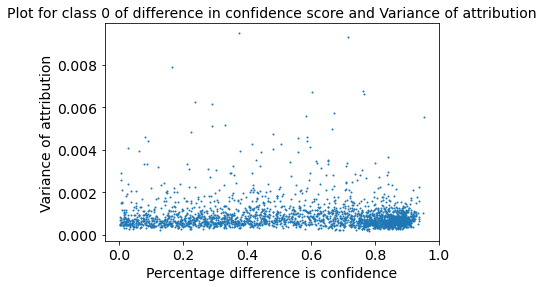

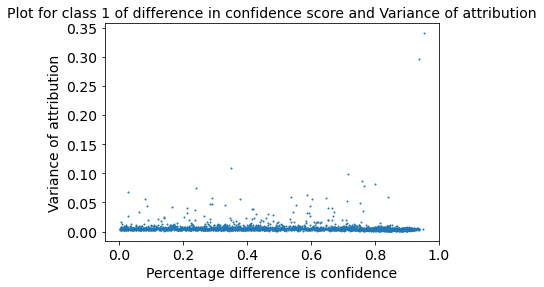

In [137]:
generate_zero_label()
generate_one_label()

In [138]:
def get_boundary_samples(condition):
    samples = []
    model.load_state_dict(model_info['model_params'])

    while len(samples) < 5:
        for i in range(0, len(outputs_softmax)):
            if condition(outputs_softmax, i):
                input_val = inputs[i]
                attr_class_0 = interpretability.smooth_grad(model, input_val, 0)[1]
                attr_class_1 = interpretability.smooth_grad(model, input_val, 1)[1]
                data = {
                        'input': inputs[i],
                        'output': outputs[i],
                        'softmax_output': outputs_softmax[i],
                        'true_label': labels[i].item(),
                        'pred_label': preds[i].item(),
                        'attr_class_0': attr_class_0,
                        'attr_class_1': attr_class_1
                        }
                samples.append(data)
        break
    return samples

In [139]:
def close_by_condition(outputs_softmax, i):
    lower_threshold = outputs_softmax[i][0] - .1
    upper_threshold = outputs_softmax[i][0] + .1

    return outputs_softmax[i][1] > lower_threshold and outputs_softmax[i][1] < upper_threshold

def get_stats(samples):
    for idx, sample in enumerate(samples):
        true_label = sample["true_label"]
        pred_label = sample["pred_label"]
        softmax_output = sample["softmax_output"]
        print(f'sample {idx}')
        print('')
        print(f'softmax output {softmax_output}')
        print(f'True label {true_label}')
        print(f'Pred label {pred_label}')
        print('')
        print('variance of attribution for class 0')
        print(np.var(sample['attr_class_0'].numpy()))
        print('mean of attribution for class 0')
        print(np.mean(sample['attr_class_0'].numpy()))
        print('')
        print('variance of attribution for class 1')
        print(np.var(sample['attr_class_1'].numpy()))
        print('mean of attribution for class 1')
        print(np.mean(sample['attr_class_1'].numpy()))
        print('')

In [140]:
def far_condition(outputs_softmax, i):
    return outputs_softmax[i][0] > .8 or outputs_softmax[i][1] > .8


samples = get_boundary_samples(lambda outputs_softmax, i: close_by_condition(outputs_softmax, i))
print("These are samples close to the decision boundary")
print("")
get_stats(samples)

These are samples close to the decision boundary

sample 0

softmax output tensor([0.5434, 0.4566])
True label 0
Pred label 0

variance of attribution for class 0
0.0024793601057110626
mean of attribution for class 0
-0.002953220148096712

variance of attribution for class 1
0.04148206798260761
mean of attribution for class 1
0.013178388576823732

sample 1

softmax output tensor([0.5454, 0.4546])
True label 0
Pred label 0

variance of attribution for class 0
0.0006559795808151742
mean of attribution for class 0
-0.0028201620227304913

variance of attribution for class 1
0.005490017767329535
mean of attribution for class 1
0.019077374743501043

sample 2

softmax output tensor([0.5049, 0.4951])
True label 0
Pred label 0

variance of attribution for class 0
0.0005533243873477989
mean of attribution for class 0
-0.0032453625742320325

variance of attribution for class 1
0.0028435995503984265
mean of attribution for class 1
0.011230663082783502

sample 3

softmax output tensor([0.4980, 0.50


softmax output tensor([0.5454, 0.4546])
True label 0
Pred label 0

variance of attribution for class 0
0.0009200907615824256
mean of attribution for class 0
-0.002115788215339999

variance of attribution for class 1
0.006237126361246268
mean of attribution for class 1
0.019467841898329667

sample 151

softmax output tensor([0.5451, 0.4549])
True label 0
Pred label 0

variance of attribution for class 0
0.002416192006678198
mean of attribution for class 0
-0.0027980882619615816

variance of attribution for class 1
0.014527548676262748
mean of attribution for class 1
0.009393071412728925

sample 152

softmax output tensor([0.5219, 0.4781])
True label 1
Pred label 0

variance of attribution for class 0
0.00032052316953107887
mean of attribution for class 0
-0.001867000436661506

variance of attribution for class 1
0.004028043192605814
mean of attribution for class 1
0.012316381570385414

sample 153

softmax output tensor([0.5068, 0.4932])
True label 0
Pred label 0

variance of attributio

In [141]:
samples = get_boundary_samples(lambda outputs_softmax, i: far_condition(outputs_softmax, i))
print("These are samples far to the decision boundary")
print("")
get_stats(samples)

These are samples far to the decision boundary

sample 0

softmax output tensor([0.9002, 0.0998])
True label 0
Pred label 0

variance of attribution for class 0
0.00042240072205968285
mean of attribution for class 0
-5.403540429122518e-06

variance of attribution for class 1
0.0017989651813966458
mean of attribution for class 1
0.003735465720850812

sample 1

softmax output tensor([0.9505, 0.0495])
True label 0
Pred label 0

variance of attribution for class 0
0.0008524956550541248
mean of attribution for class 0
0.0033085340197247007

variance of attribution for class 1
0.003324646541233184
mean of attribution for class 1
-0.004758593284316764

sample 2

softmax output tensor([0.8904, 0.1096])
True label 0
Pred label 0

variance of attribution for class 0
0.0006285547376913348
mean of attribution for class 0
-6.774936477401718e-05

variance of attribution for class 1
0.005296837726657261
mean of attribution for class 1
0.0012775487280035523

sample 3

softmax output tensor([0.9331, 0.

sample 137

softmax output tensor([0.9377, 0.0623])
True label 0
Pred label 0

variance of attribution for class 0
0.0006533890082523148
mean of attribution for class 0
0.0007178435049020279

variance of attribution for class 1
0.002455915692222651
mean of attribution for class 1
-0.0026892446324229026

sample 138

softmax output tensor([0.8768, 0.1232])
True label 0
Pred label 0

variance of attribution for class 0
0.0004391303663658539
mean of attribution for class 0
-0.0006329968368477709

variance of attribution for class 1
0.003000347976628573
mean of attribution for class 1
0.0028233929314663924

sample 139

softmax output tensor([0.8451, 0.1549])
True label 0
Pred label 0

variance of attribution for class 0
0.000858181224851344
mean of attribution for class 0
-0.0022007082782432904

variance of attribution for class 1
0.0036451573003309303
mean of attribution for class 1
0.004342422576013889

sample 140

softmax output tensor([0.8370, 0.1630])
True label 0
Pred label 0

varianc

sample 262

softmax output tensor([0.9486, 0.0514])
True label 0
Pred label 0

variance of attribution for class 0
0.0005651681896888335
mean of attribution for class 0
0.0008480842044046573

variance of attribution for class 1
0.002830902991668996
mean of attribution for class 1
-0.0069433644393078735

sample 263

softmax output tensor([0.8119, 0.1881])
True label 0
Pred label 0

variance of attribution for class 0
0.001286896717386632
mean of attribution for class 0
-0.0012445555432427232

variance of attribution for class 1
0.004907575564112888
mean of attribution for class 1
0.008246486635287669

sample 264

softmax output tensor([0.1200, 0.8800])
True label 0
Pred label 1

variance of attribution for class 0
0.005277442025842138
mean of attribution for class 0
-0.005874683544026547

variance of attribution for class 1
0.07780998765793312
mean of attribution for class 1
0.028391661327674084

sample 265

softmax output tensor([0.9177, 0.0823])
True label 0
Pred label 0

variance of 

sample 387

softmax output tensor([0.9516, 0.0484])
True label 0
Pred label 0

variance of attribution for class 0
0.0007283270758709589
mean of attribution for class 0
0.0021793032993935634

variance of attribution for class 1
0.004358523605110639
mean of attribution for class 1
-0.0010093892116893033

sample 388

softmax output tensor([0.8977, 0.1023])
True label 0
Pred label 0

variance of attribution for class 0
0.0008043954054133847
mean of attribution for class 0
0.001401506171200909

variance of attribution for class 1
0.002344301824006215
mean of attribution for class 1
0.0001469487427320414

sample 389

softmax output tensor([0.9488, 0.0512])
True label 0
Pred label 0

variance of attribution for class 0
0.000728738658046556
mean of attribution for class 0
0.0009415515349533346

variance of attribution for class 1
0.0024511033164812857
mean of attribution for class 1
-0.002403625179953609

sample 390

softmax output tensor([0.8936, 0.1064])
True label 0
Pred label 0

variance 

softmax output tensor([0.9252, 0.0748])
True label 0
Pred label 0

variance of attribution for class 0
0.0006911460210461178
mean of attribution for class 0
0.0019867583191820167

variance of attribution for class 1
0.002499150551622085
mean of attribution for class 1
-0.0027620495145759955

sample 517

softmax output tensor([0.9604, 0.0396])
True label 0
Pred label 0

variance of attribution for class 0
0.0007878639232198405
mean of attribution for class 0
0.002479317654804767

variance of attribution for class 1
0.002969514885915994
mean of attribution for class 1
-0.0048557190570892765

sample 518

softmax output tensor([0.9379, 0.0621])
True label 0
Pred label 0

variance of attribution for class 0
0.0006911810664374694
mean of attribution for class 0
0.0017484366007281633

variance of attribution for class 1
0.002381891051530075
mean of attribution for class 1
-0.002434074526307074

sample 519

softmax output tensor([0.9473, 0.0527])
True label 0
Pred label 0

variance of attribut

softmax output tensor([0.8463, 0.1537])
True label 0
Pred label 0

variance of attribution for class 0
0.00044039003331216713
mean of attribution for class 0
-0.000532519685394128

variance of attribution for class 1
0.0015374533821928156
mean of attribution for class 1
0.003933944488849825

sample 648

softmax output tensor([0.9444, 0.0556])
True label 0
Pred label 0

variance of attribution for class 0
0.000425961697825719
mean of attribution for class 0
-0.0001381747633478377

variance of attribution for class 1
0.0026135363181348913
mean of attribution for class 1
-0.004603082468095367

sample 649

softmax output tensor([0.8961, 0.1039])
True label 1
Pred label 0

variance of attribution for class 0
0.0007589458247873837
mean of attribution for class 0
-0.0009233226395398039

variance of attribution for class 1
0.0025393211520497723
mean of attribution for class 1
0.0005216922559991556

sample 650

softmax output tensor([0.8679, 0.1321])
True label 0
Pred label 0

variance of attri

softmax output tensor([0.8382, 0.1618])
True label 0
Pred label 0

variance of attribution for class 0
0.0009615017630943796
mean of attribution for class 0
-0.0017953345105047893

variance of attribution for class 1
0.0023968081265336913
mean of attribution for class 1
0.003267591503478614

sample 739

softmax output tensor([0.9154, 0.0846])
True label 0
Pred label 0

variance of attribution for class 0
0.0003835584657748587
mean of attribution for class 0
0.0025748391792803104

variance of attribution for class 1
0.002277655179408281
mean of attribution for class 1
-0.0005442228031450823

sample 740

softmax output tensor([0.9002, 0.0998])
True label 0
Pred label 0

variance of attribution for class 0
0.0005389440001405556
mean of attribution for class 0
0.0013859753493949082

variance of attribution for class 1
0.0025798982552924536
mean of attribution for class 1
-0.0008874343289353722

sample 741

softmax output tensor([0.9296, 0.0704])
True label 0
Pred label 0

variance of attri

softmax output tensor([0.9396, 0.0604])
True label 0
Pred label 0

variance of attribution for class 0
0.0005148352148979361
mean of attribution for class 0
0.0040154664326382365

variance of attribution for class 1
0.002395146181546972
mean of attribution for class 1
-0.0028652666900198416

sample 795

softmax output tensor([0.9502, 0.0498])
True label 0
Pred label 0

variance of attribution for class 0
0.0006803963891452664
mean of attribution for class 0
0.0024118682326838927

variance of attribution for class 1
0.005321324058969606
mean of attribution for class 1
0.002925979916860971

sample 796

softmax output tensor([0.9469, 0.0531])
True label 0
Pred label 0

variance of attribution for class 0
0.0006072401225754843
mean of attribution for class 0
0.002515136484829721

variance of attribution for class 1
0.00489471588833339
mean of attribution for class 1
-0.001948769581388987

sample 797

softmax output tensor([0.9543, 0.0457])
True label 0
Pred label 0

variance of attribution


softmax output tensor([0.8567, 0.1433])
True label 0
Pred label 0

variance of attribution for class 0
0.0007936013381372872
mean of attribution for class 0
-0.00021770528014411345

variance of attribution for class 1
0.0077125699773078595
mean of attribution for class 1
0.006446990723942318

sample 919

softmax output tensor([0.9187, 0.0813])
True label 1
Pred label 0

variance of attribution for class 0
0.0007274518610289472
mean of attribution for class 0
-0.0008905924247187002

variance of attribution for class 1
0.00286753705457081
mean of attribution for class 1
-0.0035045726338439934

sample 920

softmax output tensor([0.9092, 0.0908])
True label 0
Pred label 0

variance of attribution for class 0
0.001444060211788799
mean of attribution for class 0
0.00035975645882812857

variance of attribution for class 1
0.009418703330842711
mean of attribution for class 1
0.0010857820695096606

sample 921

softmax output tensor([0.9315, 0.0685])
True label 0
Pred label 0

variance of attri

sample 1043

softmax output tensor([0.8865, 0.1135])
True label 0
Pred label 0

variance of attribution for class 0
0.0005673227508940652
mean of attribution for class 0
-0.0005871463233043024

variance of attribution for class 1
0.0035705907121992564
mean of attribution for class 1
0.007622375336264471

sample 1044

softmax output tensor([0.9208, 0.0792])
True label 0
Pred label 0

variance of attribution for class 0
0.00035919736726435143
mean of attribution for class 0
0.0014198591666928146

variance of attribution for class 1
0.0039177676944704455
mean of attribution for class 1
-0.001429557327228582

sample 1045

softmax output tensor([0.9149, 0.0851])
True label 0
Pred label 0

variance of attribution for class 0
0.001326439280666472
mean of attribution for class 0
-9.404269564708836e-05

variance of attribution for class 1
0.010867930727117591
mean of attribution for class 1
0.0007602798903514905

sample 1046

softmax output tensor([0.8866, 0.1134])
True label 0
Pred label 0

va

softmax output tensor([0.9103, 0.0897])
True label 1
Pred label 0

variance of attribution for class 0
0.0025853496124487794
mean of attribution for class 0
0.0005581631467859587

variance of attribution for class 1
0.012810494511578974
mean of attribution for class 1
0.005957513708160721

sample 1174

softmax output tensor([0.9313, 0.0687])
True label 0
Pred label 0

variance of attribution for class 0
0.001357867400863927
mean of attribution for class 0
0.0010098548625206763

variance of attribution for class 1
0.006290945396307805
mean of attribution for class 1
-0.004335437736976923

sample 1175

softmax output tensor([0.8988, 0.1012])
True label 0
Pred label 0

variance of attribution for class 0
0.0005052724307818785
mean of attribution for class 0
0.0012075599262175427

variance of attribution for class 1
0.0028507553210818104
mean of attribution for class 1
0.0033521932535509526

sample 1176

softmax output tensor([0.8883, 0.1117])
True label 0
Pred label 0

variance of attribu


sample 1302

softmax output tensor([0.8677, 0.1323])
True label 0
Pred label 0

variance of attribution for class 0
0.000924941679619086
mean of attribution for class 0
0.0008762315525647109

variance of attribution for class 1
0.013763189553820488
mean of attribution for class 1
0.0087522446119281

sample 1303

softmax output tensor([0.9207, 0.0793])
True label 0
Pred label 0

variance of attribution for class 0
0.0010167889315688711
mean of attribution for class 0
-0.0003758221748755762

variance of attribution for class 1
0.0015672918659748805
mean of attribution for class 1
-0.0032869369360475492

sample 1304

softmax output tensor([0.8975, 0.1025])
True label 0
Pred label 0

variance of attribution for class 0
0.0005165523957798948
mean of attribution for class 0
-0.0007512355666415808

variance of attribution for class 1
0.0010685162561454176
mean of attribution for class 1
-0.0018076127218047407

sample 1305

softmax output tensor([0.8775, 0.1225])
True label 0
Pred label 0

va